In [1]:
import matplotlib.pyplot as plt 
import os
import numpy as np
import os
import glob
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from PIL import Image

#path to the image.
def callImage(path):
    x1 = Image.open(
        path).convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));
    y_dat1 = np.asarray(y1, dtype=np.uint8)     
    return y_dat1

#Resize image into n x n pixel ( pixel is an int)
def imageResize(data,pixel):
    image = Image.fromarray(data,'L')
    image= image.resize((pixel, pixel))
    image=np.asarray(image.getdata(), dtype=np.float64).reshape((image.size[1], image.size[0]))
    image=np.asarray(image, dtype=np.uint8)    
    return image

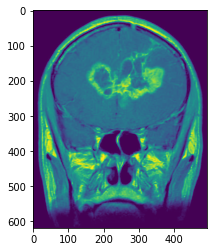

In [3]:
data_img = callImage("image.jpg")
plt.imshow(data_img)

In [4]:
image = imageResize(data_img,16) # Can be printed with plt.imshow(image)
image.flatten()

array([  0,   0,   0,   0,   1,  42,  78,  83,  89,  79,  42,   3,   0,
         0,   0,   0,   0,   0,   0,  37,  96, 113,  99,  87,  91, 100,
       108, 104,  45,   0,   0,   0,   0,   0,  63, 111,  96,  88,  93,
        98,  95,  92, 102, 104, 105,  65,   1,   0,   0,  47, 106,  92,
        93, 101, 107, 100, 105, 120, 117,  92,  83,  87,  44,   0,  15,
        84,  76,  93,  99, 139, 124, 123, 103, 104, 157, 157,  96,  77,
        77,  11,  55,  93,  80,  95,  99, 138, 120, 158, 177, 130, 160,
       157,  89,  78,  78,  50,  72, 110,  77,  90,  95, 102, 121, 123,
       143, 143, 112,  91,  87,  75, 100,  75,  75, 117,  73,  94,  88,
        97, 101,  96, 103,  94,  91,  89,  90,  75, 114,  75,  80, 133,
        69,  86,  83,  95, 100,  81,  83,  94,  92,  84,  82,  75, 127,
        79,  83, 178,  81,  72,  84, 110,  55,  24,   9,  46, 111,  80,
        67,  84, 167,  98,  72, 150, 101, 136, 149, 127, 102,  57,  43,
        87, 146, 140, 123,  98, 148,  82,  56, 130,  88, 145, 19

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import  Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator

nqubits=8

In [14]:
def phaseFlip(testdata):
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,8) for x in arr_data]);
    sum_const=np.sqrt(sum(np.absolute(encoding_data) ** 2))
    encoding_norm=encoding_data/sum_const
    m=np.diag(np.exp(complex(0,1)*np.pi*encoding_norm))
    return m

In [48]:
def convert_to_circuit(image):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    m = phaseFlip(np.array(image))
    #Initilzation
    qc = QuantumCircuit(qr, name='UI')
    #qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
    qc.unitary(m, range(nqubits), label='UI')
    print(qc)
    return qc

    
    

In [50]:
qc= convert_to_circuit(image)
qc = qc.decompose()


        ┌─────┐
q143_0: ┤0    ├
        │     │
q143_1: ┤1    ├
        │     │
q143_2: ┤2    ├
        │     │
q143_3: ┤3    ├
        │  UI │
q143_4: ┤4    ├
        │     │
q143_5: ┤5    ├
        │     │
q143_6: ┤6    ├
        │     │
q143_7: ┤7    ├
        └─────┘
        ┌───────────┐
q143_0: ┤0          ├
        │           │
q143_1: ┤1          ├
        │           │
q143_2: ┤2          ├
        │           │
q143_3: ┤3          ├
        │  Isometry │
q143_4: ┤4          ├
        │           │
q143_5: ┤5          ├
        │           │
q143_6: ┤6          ├
        │           │
q143_7: ┤7          ├
        └───────────┘


In [17]:
# GREY_THRESHOLD = 0.33
# WHITE_THRESHOLD = 0.66

# x_train_bin = np.array([ (math.pi / 2) if x_train > WHITE_THRESHOLD else 0 if x_train<GREY_THRESHOLD else (math.pi / 4) ], dtype=np.float32)
# x_test_bin = np.array([0 if x_train > WHITE_THRESHOLD else (math.pi / 2) if x_train<GREY_THRESHOLD else (math.pi / 4) ], dtype=np.float32)

In [25]:
# def convert_to_circuit(image):
#     """Encode truncated classical image into quantum datapoint."""
#     values = np.ndarray.flatten(image)
#     circuit = Circuit().h(range(9))
#     for i, value in enumerate(values):
#         circuit.ry(i, value)
#         circuit.X(i)
#     return circuit
!pip install toolz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 1.2 MB/s eta 0:00:00ta 0:00:01


In [33]:
from collections import OrderedDict
from toolz import partition
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import  Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator

nqubits=8

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s


def phaseFlipM(testdata):
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,8) for x in arr_data]);
    sum_const=np.sqrt(sum(np.absolute(encoding_data) ** 2))
    encoding_norm=encoding_data/sum_const
    m=np.diag(np.exp(complex(0,1)*np.pi*encoding_norm))
    return m

def grover(itr,data):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    m = phaseFlipM(np.array(data))
    #Initilzation
    qc = QuantumCircuit(qr, name='UI1')
    #qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
    qc.unitary(m, range(nqubits), label='UI2')

    my_inst = qc.to_instruction()

    #Grover Search
    my_circuit = QuantumCircuit(qr,cr)
    for qubit in range(nqubits):
        my_circuit.h(qubit)

    for i in range(itr):
        my_circuit.append(my_inst, range(nqubits))
        my_circuit.append(diffuser(nqubits), range(nqubits))

    my_circuit.measure(qr[:],cr[:])
    nshot=100000;
    print(my_circuit)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(my_circuit, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    return count

def countBitstring(count):
    f=[]
    for i in range(2**nqubits):
        if format(i, '#010b')[2:10] in count:
            f.append(count[format(i, '#010b')[2:10]])
        else:
            f.append(0)
    return np.array(list(f))

def imigize1(count):
    countlist=countBitstring(count)
    out_img=np.array(list(partition(16, countlist)))/max(countlist);
    return out_img.squeeze()

In [34]:
grover(5, image)


        ┌───┐┌──────┐┌────────────────┐┌──────┐┌────────────────┐┌──────┐»
q146_0: ┤ H ├┤0     ├┤0               ├┤0     ├┤0               ├┤0     ├»
        ├───┤│      ││                ││      ││                ││      │»
q146_1: ┤ H ├┤1     ├┤1               ├┤1     ├┤1               ├┤1     ├»
        ├───┤│      ││                ││      ││                ││      │»
q146_2: ┤ H ├┤2     ├┤2               ├┤2     ├┤2               ├┤2     ├»
        ├───┤│      ││                ││      ││                ││      │»
q146_3: ┤ H ├┤3     ├┤3               ├┤3     ├┤3               ├┤3     ├»
        ├───┤│  UI1 ││  circuit-12099 ││  UI1 ││  circuit-12102 ││  UI1 │»
q146_4: ┤ H ├┤4     ├┤4               ├┤4     ├┤4               ├┤4     ├»
        ├───┤│      ││                ││      ││                ││      │»
q146_5: ┤ H ├┤5     ├┤5               ├┤5     ├┤5               ├┤5     ├»
        ├───┤│      ││                ││      ││                ││      │»
q146_6: ┤ H ├┤6     ├┤6  

{'01110111': 368,
 '11010011': 352,
 '00110111': 326,
 '01000110': 393,
 '01000111': 359,
 '00010111': 402,
 '01110001': 373,
 '10111101': 353,
 '11011110': 386,
 '00110011': 371,
 '10100100': 444,
 '11010001': 379,
 '10111000': 415,
 '11111011': 431,
 '00101000': 372,
 '11001101': 339,
 '00111101': 370,
 '11100100': 357,
 '10000000': 389,
 '10011010': 361,
 '10000001': 383,
 '11110011': 436,
 '10001001': 326,
 '00101001': 376,
 '01101011': 365,
 '11011001': 432,
 '00100010': 334,
 '01100011': 376,
 '10001000': 364,
 '01001000': 380,
 '10110111': 390,
 '10011101': 348,
 '01000101': 400,
 '10010011': 392,
 '11101110': 420,
 '10001010': 404,
 '01100000': 343,
 '00111111': 434,
 '11110001': 444,
 '00111110': 372,
 '10011100': 355,
 '00111010': 396,
 '11111110': 393,
 '11110100': 416,
 '01110110': 382,
 '01101000': 409,
 '10101111': 380,
 '01101100': 393,
 '10100010': 349,
 '00011011': 361,
 '11001000': 380,
 '01101101': 388,
 '00000010': 439,
 '10101100': 388,
 '01011111': 373,
 '01010100

        ┌───┐┌──────┐┌────────────────┐┌──────┐┌────────────────┐┌──────┐»
q172_0: ┤ H ├┤0     ├┤0               ├┤0     ├┤0               ├┤0     ├»
        ├───┤│      ││                ││      ││                ││      │»
q172_1: ┤ H ├┤1     ├┤1               ├┤1     ├┤1               ├┤1     ├»
        ├───┤│      ││                ││      ││                ││      │»
q172_2: ┤ H ├┤2     ├┤2               ├┤2     ├┤2               ├┤2     ├»
        ├───┤│      ││                ││      ││                ││      │»
q172_3: ┤ H ├┤3     ├┤3               ├┤3     ├┤3               ├┤3     ├»
        ├───┤│  UI1 ││  circuit-14495 ││  UI1 ││  circuit-14498 ││  UI1 │»
q172_4: ┤ H ├┤4     ├┤4               ├┤4     ├┤4               ├┤4     ├»
        ├───┤│      ││                ││      ││                ││      │»
q172_5: ┤ H ├┤5     ├┤5               ├┤5     ├┤5               ├┤5     ├»
        ├───┤│      ││                ││      ││                ││      │»
q172_6: ┤ H ├┤6     ├┤6  

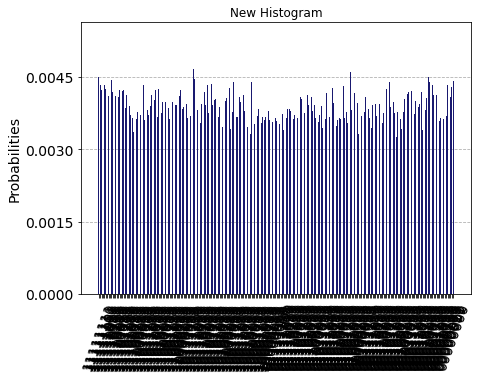

In [36]:
plot_histogram(grover(5,image), color='midnightblue', title="New Histogram",bar_labels =False,sort = 'desc')